# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [227]:
from collections.abc import Sequence
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from timeit import timeit

np.random.seed(42)
tf.random.set_seed(42)

In [228]:
## One hot for numpy
def np_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### **Sampling Behaviour of `tfp.Distributions`**

In [229]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[0., 0., 1.], 
                     [1., 0., 0.]])
print(probs.shape)
print(tfd.Categorical(probs=probs).sample(4))

(2, 3)
tf.Tensor(
[[2 0]
 [2 0]
 [2 0]
 [2 0]], shape=(4, 2), dtype=int32)


In [230]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
np.round(tfd.Dirichlet(concentration=conc).sample().numpy())

array([[0., 0., 1.],
       [0., 0., 0.]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

### Understand The indices in this Notebook

- $K$ is the number of topics 
- $D$ is the number of documents
- $I_d$ is the number of words in document $d$
- $N_{\mathrm{max}}$ is the maximum number of words per doument, i. e. $N_{\mathrm{max}} = \max_d \{I_d\}$
- $T$ is the total number of words, i. e. $T = \sum_d I_d$
- $V$ is the vocabulary size which should be a square of an integer for the visualization purposes of this notebook

### **1. Specify global parameters**

In [231]:
sqrtV   = 5       # Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
K       = 2*sqrtV # Number of Topics
D       = 1000    # Number of documents
N_fixed = 100     # Number of words per document

V = int(sqrtV**2)

### **2. Generating Data**

In [232]:
def generate_LDA(D: int, K: int, sqrtV: int, N: int=100, Alpha: float=1.) -> tuple():
    """
    Generates LDA-Data from the LDA generative Process. 
    Thetas get constructed as rows and columns of a quadratic sqrtV-grid.
    """
  

    ## Word grid
    V = int(sqrtV**2)
    V_grid = np.reshape(np.arange(0, V), newshape=(sqrtV, sqrtV))


    ## Topic-Word Distribution
    #  Words belonging to a topic are rows and columns
    Theta_idx = [row for row in V_grid] + [col for col in V_grid.T]
    Theta = np.zeros((K, V))
    for k, idx in enumerate(Theta_idx):
        Theta[k, idx] = 1. / sqrtV
    Theta = tf.constant(Theta, dtype=tf.float32)


    ## Document-Topic Distribution
    dist_Pi = tfd.Dirichlet(concentration=K*[Alpha])
    Pi      = dist_Pi.sample(D)


    ## Topic Assignments of word c_{dik} of word w_{di}
    dist_C_ND = tfd.Categorical(probs=Pi)
    C_ND  = dist_C_ND.sample(N)
    C_DN  = tf.transpose(C_ND)
    C_DNK = tf.one_hot(C_DN, depth=K, axis=-1)


    ## Draw words w_{di}
    dist_W_DN = tfd.Categorical(probs=tf.gather(Theta, C_DN))
    W_DN      = dist_W_DN.sample()


    return Theta, Pi, C_DN, C_DNK, W_DN, N_fixed

In [233]:
Theta, Pi, C_DN, C_DNK, W_DN, N = generate_LDA(D, K, sqrtV, N=N_fixed, Alpha=0.1)

In [234]:
print("Topics for the Words in Document d=11:")
print(C_DN[11, :])
print("\nWords in Document d=11:")
print(W_DN[11, :])

Topics for the Words in Document d=11:
tf.Tensor(
[3 6 4 4 3 8 4 6 4 3 6 4 6 3 6 3 4 6 4 3 4 3 4 4 3 3 3 4 4 4 3 6 3 4 4 3 3
 6 4 4 3 3 6 4 6 4 3 3 4 3 4 3 6 4 4 3 4 6 4 3 3 3 6 4 3 4 3 4 4 4 4 4 3 4
 3 4 6 4 4 6 3 4 4 3 4 3 8 3 3 4 3 4 3 3 3 6 3 6 3 4], shape=(100,), dtype=int32)

Words in Document d=11:
tf.Tensor(
[17 11 20 20 16 18 24  1 23 15  6 23  1 19  1 18 24 21 20 18 23 19 23 20
 18 16 16 23 24 24 17 11 15 20 23 18 18 11 22 23 17 18 21 20 11 21 18 17
 21 19 24 19  1 20 22 15 20  1 24 17 19 16 16 23 19 23 18 23 24 23 22 22
 17 23 15 20 21 21 24 11 19 21 21 17 20 15  3 15 19 20 15 21 15 16 16 21
 15 21 16 22], shape=(100,), dtype=int32)


### **3. Checking Shapes**

In [235]:
## For development purposes:
def print_all_shapes():
    print("Π-Shape (D docs x K topics)")
    print(Pi.shape)
    print("\nΘ-Shape (K topic x V vocab)")
    print(Theta.shape)
    print("\nC_DN-Shape (Topic for each word T=sum_d I_d)")
    print(C_DN.shape)
    print("\nC_DNK-Shape (one-hot for each topic k in {1, K})")
    print(C_DNK.shape)
    print("\nW_DN-Shape (sum_d I_d words)")
    print(W_DN.shape)

In [236]:
print_all_shapes()

Π-Shape (D docs x K topics)
(1000, 10)

Θ-Shape (K topic x V vocab)
(10, 25)

C_DN-Shape (Topic for each word T=sum_d I_d)
(1000, 100)

C_DNK-Shape (one-hot for each topic k in {1, K})
(1000, 100, 10)

W_DN-Shape (sum_d I_d words)
(1000, 100)


## **Visualization**

In [237]:
def format_to_img(arr, sqrtV=sqrtV):
    vals = dict(zip(*np.unique(arr, return_counts=True)))
    img = []

    for i in range(int(sqrtV**2)):
        if i in vals:
            img.append(vals[i])
        else:
            img.append(0)

    img = np.array(img).reshape(sqrtV, sqrtV)

    return img

tf.Tensor(
[6.1480580e-03 8.0593541e-02 3.1065012e-04 6.2264545e-09 1.5178669e-13
 2.3717478e-02 1.8988621e-03 6.0282439e-01 1.2861227e-07 2.8450683e-01], shape=(10,), dtype=float32)


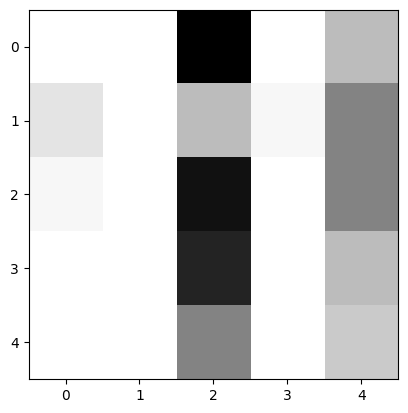

In [238]:
d = 100
print(Pi[d, :])
plt.figure()
plt.imshow(format_to_img(W_DN[d, :]), cmap="Greys")
plt.show()

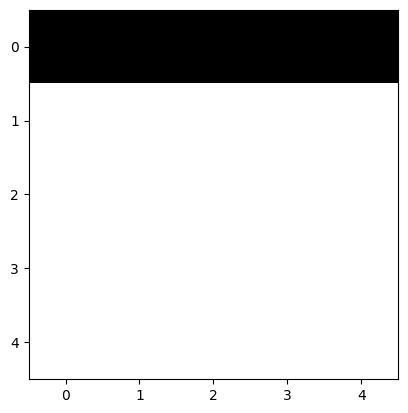

In [239]:
plt.imshow(tf.reshape(Theta[0,:], (sqrtV, sqrtV)), cmap="Greys")

## **Toy Document**

In [240]:
## Fixing single Pi
Pi0 = tf.constant([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

## Sampling single C
dist_C_N = tfd.Categorical(probs=Pi0)
C_N      = dist_C_N.sample(N)
C_0N     = tf.expand_dims(C_N, axis=0)
C_NK     = tf.one_hot(C_N, V, axis=-1)
C_0NK    = tf.expand_dims(C_NK, axis=0)

## Draw words for this single C
dist_W_0N = tfd.Categorical(probs=tf.gather(Theta, C_0N))
W_0N      = dist_W_0N.sample()

In [241]:
W_0N

<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[17, 16, 19, 19, 17, 19, 19, 15, 19, 16, 15, 16, 19, 17, 18, 17,
        18, 19, 16, 16, 18, 19, 18, 19, 15, 16, 19, 19, 15, 18, 15, 16,
        18, 16, 19, 18, 19, 19, 18, 15, 19, 17, 17, 17, 15, 17, 17, 15,
        15, 15, 18, 15, 16, 19, 16, 18, 19, 16, 19, 16, 19, 18, 18, 19,
        17, 19, 17, 17, 17, 19, 17, 15, 18, 16, 16, 15, 19, 18, 18, 17,
        19, 19, 15, 16, 15, 17, 19, 15, 16, 19, 18, 15, 17, 19, 15, 15,
        18, 19, 16, 16]])>

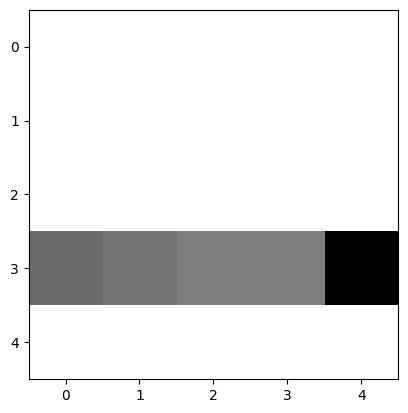

In [242]:
plt.imshow(format_to_img(W_0N, sqrtV=sqrtV), cmap="Greys")

## **Gibbs Sampler**

### **N-Tensor**
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
as much as possible. Due to the fact, that the document lengths are variable there is the choice between looping over the number of documents or padding the documents to a unique length. The padding does not need a word-token, it can be done by padding the $C$ matrix with $0$, therefore it will not affect $N$. Then the counting can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

#### 1. Multiloop over all Dimensions

Mainly for test purposes. Horribly slow.

In [243]:
def multiloop_N_tensor(W_DN, C_DNK, V=V):

    ## Extracting shapes
    D = C_DNK.shape[0]
    N = C_DNK.shape[1]
    K = C_DNK.shape[2]

    ## To Numpy
    W_DN  = W_DN.numpy()
    C_DNK = C_DNK.numpy()
    N_DKV = np.zeros(shape=(D, K, V))
    
    for d in tqdm(range(D)):
        for k in range(K):
            for v in range(V):
                for i in range(N):
                    if W_DN[d, i] == v and C_DNK[d, i, k] == 1:
                        N_DKV[d, k, v] += 1

    return N_DKV

In [244]:
# N_test1 = multiloop_N_tensor(W_DN, C_DNK, V=V)

#### 2. Vectorized using `tf`

In [245]:
## Actual n-Tensor
@tf.function
def tf_N_tensor(W_DN, C_DNK, V=V):

    ## Extracting shapes
    D = C_DNK.shape[0]
    N = C_DNK.shape[1]
    K = C_DNK.shape[2]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to V+1 instead from 0 to V. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W_DN + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_DNK_int = tf.cast(C_DNK, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_DNK_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DNKVp1 = tf.one_hot(C_Dot_W, V+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DNKV = N_DNKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    assert N_DNKV.shape[1] == N
    N_DKV = tf.reduce_sum(N_DNKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

In [246]:
N_test2 = tf_N_tensor(W_DN, C_DNK)

### **Sampling $C$**

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^{N} \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution. 

https://youtu.be/z2q7LhsnWNg?t=3878

In [247]:
## Vectorized C-Sampling
@tf.function
def sample_C(Theta, Pi, W_DN):
    ## Extracting shapes
    D = W_DN.shape[0]
    N = W_DN.shape[1]
    K = Pi.shape[-1]

    ## Numerator
    Theta_KDN = tf.gather(Theta, W_DN, axis=-1) 
    Pi_block  = tf.stack(N * [tf.transpose(Pi)], axis=-1)
    numerator = tf.math.multiply(Pi_block, Theta_KDN)
    numerator = tf.reshape(numerator, (D, N, K))

    ## Dividing by Denominator
    denominator = tf.reduce_sum(numerator, axis=-1)
    numerator = numerator / tf.expand_dims(denominator, axis=-1)

    ## Sampling
    C_DN_dist = tfd.Categorical(probs=numerator)
    C_DN      = C_DN_dist.sample()

    ## One-Hot-Encoding
    C_DNK = tf.one_hot(C_DN, K, axis=-1)

    return C_DNK

In [248]:
sample_C(Theta, Pi, W_DN)

<tf.Tensor: shape=(1000, 100, 10), dtype=float32, numpy=
array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

### **Sampling $\Theta$ and $\Pi$**

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot}) \, .
    \end{align*}
$$
$\Theta$ and $\Pi$ are neither dependent on the number of words per document nor do they have an $I_d$ dimension. Therefore it is much easier to sample them:

In [249]:
## tfd.Dirichlet sampling behaviour:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
np.round(tfd.Dirichlet(concentration=conc).sample().numpy(), 1)

array([[0. , 1. , 0. ],
       [0.1, 0.5, 0.4]], dtype=float32)

In [250]:
@tf.function
def sample_Theta(N_DKV, beta):
    conc = beta + tf.reduce_sum(N_DKV, axis=0)
    dist_Theta = tfd.Dirichlet(concentration=conc)
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    conc = alpha + tf.reduce_sum(N_DKV, axis=-1)
    dist_Pi = tfd.Dirichlet(concentration=conc)
    Pi      = dist_Pi.sample()
    return Pi

In [251]:
## Random Initialization of Prior Alpha and Beta.
#  They do not acutally matter much but could be optimized by Type II MAP or MLE.
beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

## Calculate one N_DKV for test purposes
N_test = tf_N_tensor(W_DN, C_DNK)

In [258]:
N_test

<tf.Tensor: shape=(1000, 10, 25), dtype=float32, numpy=
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 7.,  8.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 5.,  3.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0

In [252]:
(alpha+tf.reduce_sum(N_test, axis=-1))

<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[-1.2608839e+00,  9.1786194e-01,  9.1221561e+00, ...,
        -7.0766944e-01,  4.4381943e-01,  7.7463406e-01],
       [-9.2693049e-01,  2.1940475e+01, -3.2412674e+00, ...,
        -4.3014133e-01, -4.4004449e-01,  1.3074058e-01],
       [ 4.0441273e+01,  4.5564137e+01,  4.1631637e+00, ...,
        -6.0021687e-01,  6.9802083e-02, -3.8531360e-01],
       ...,
       [ 1.6316175e+01, -1.9856919e-01, -2.0614054e+00, ...,
         3.7086761e+01,  3.6467163e+01, -8.1926644e-01],
       [ 9.5538855e-01,  4.2802467e+01, -8.9381641e-01, ...,
        -1.8487675e-01, -1.5057478e+00,  8.3994454e-01],
       [ 1.6857017e+00,  3.5375768e-01, -4.7855428e-01, ...,
         6.3141859e-01,  7.9906809e-01,  9.7006134e+01]], dtype=float32)>

In [253]:
test_Theta = sample_Theta(N_test, beta)
test_Pi    = sample_Pi(N_test, alpha)

assert test_Theta.shape == Theta.shape
assert test_Pi.shape == Pi.shape

### **Main Loop**

In [254]:
N_iter = 200

C_DN_  = tf.constant(np.random.randint(0, 10, size=W_DN.shape))
C_DNK_ = tf.one_hot(C_DN_, K, axis=-1)

# beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
# alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)
beta  = tf.ones(shape=(K, V), dtype=tf.float32)
alpha = tf.ones(shape=(D, K), dtype=tf.float32)

Note that `W_DN` and `N` are fixed since they are observable from the data and do therefore not have to be initialized.

In [255]:
Theta_store = []

for iter in tqdm(range(N_iter)):

    ## Calculate N_DKV_ from W_DN and C_DNK_
    N_DKV_ = tf_N_tensor(W_DN, C_DNK_)
    
    ## Sample Theta_ and Pi_ from N_DKV_ and priors
    Theta_ = sample_Theta(N_DKV_, beta)
    Pi_    = sample_Pi(N_DKV_, alpha)

    ## Sample next C_DNK_ from Theta, Pi
    C_DNK_ = sample_C(Theta_, Pi_, W_DN)

    Theta_store.append(Theta_)

100%|██████████| 200/200 [00:08<00:00, 24.28it/s]


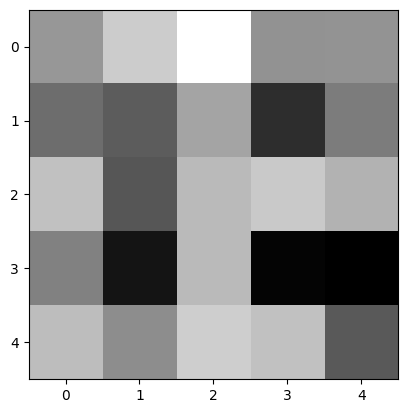

In [256]:
plt.imshow(tf.reshape(Theta_[6,:], (sqrtV, sqrtV)), cmap="Greys")

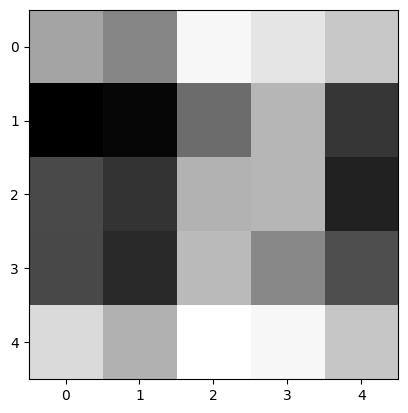

In [257]:
Theta_stack = tf.stack(Theta_store, axis=-1)
Theta_mean = tf.reduce_mean(Theta_stack, axis=-1)
plt.imshow(tf.reshape(Theta_mean[2,:], (sqrtV, sqrtV)), cmap="Greys")